In [1]:
import sys
sys.path.append("..")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # or "0,1" for multiple GPUs

In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import torch
from grins.config import EXTERNAL_DATA_DIR
from PIL import Image

/home/nicola/Development/GRINS/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-20 10:10:17.385 | INFO     | grins.config:<module>:11 - PROJ_ROOT path is: /home/nicola/Development/GRINS


In [3]:
MIT_PLACE_PULSE_DIR = EXTERNAL_DATA_DIR / "mit-place-pulse"
IMAGES_DIR = MIT_PLACE_PULSE_DIR / "gsv" / "final_photo_dataset"

In [10]:
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct-AWQ", torch_dtype=torch.float16, device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct-AWQ",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct-AWQ", min_pixels=min_pixels, max_pixels=max_pixels)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


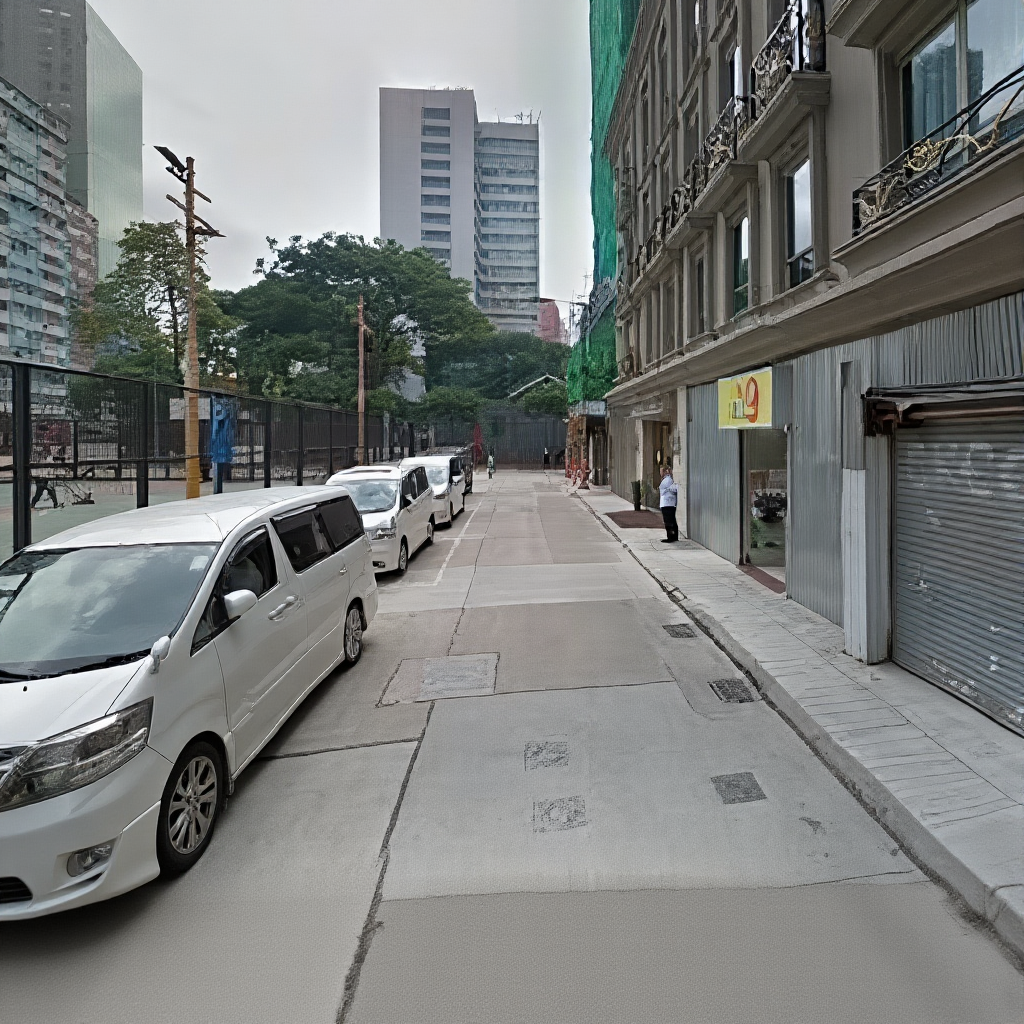

In [49]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Identify 1 to 5 regions in the image that could be edited to improve the urban environment with a focus on infrastructure, safety, and public space renewal. Each region must have one precise, non-overlapping bounding box tightly fitted around the object of interest. Avoid very small or irrelevant objects such as cars or people. For each region, generate a clear editing instruction. Each instruction must:\n\n- Begin with an action verb such as 'Add', 'Remove', 'Paint', 'Replace', or 'Install'.\n- Refer only to the object inside the bounding box (do not reference anything outside).\n- Specify the transformation in practical terms, using materials, colors, or urban design elements.\n- Focus on structural, safety, and public-space related changes (e.g., crosswalks, façades, lighting, greenery, waste management).\n\nDo not include justifications or explanations in the instructions — only the edit itself.\n\nExample edits:\n- 'Add a pedestrian crosswalk with bold white zebra stripes on the road surface.'\n- 'Install a modern street lamp for improved lighting.'\n- 'Replace the blank wall with a vertical green garden.'\n- 'Paint the building façade with neutral pastel tones.'\n- 'Place a public trash bin in a clean, accessible design.'\n\nOutput strictly as a list of objects in the form:\n{\"bbox_2d\": [x1, y1, x2, y2], \"prompt\": \"<editing instruction>\"}",
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
images = [Image.open(IMAGES_DIR / "50e5f7d4d7c3df413b00056a.jpg").convert("RGB")]
images = [Image.open("output.png").convert("RGB")]
inputs = processor(
    text=[text],
    images=images,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

images[0]

In [50]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['{"bbox_2d": [684, 350, 741, 409], "prompt": "Paint the signboard with bright, eye-catching colors."}\n{"bbox_2d": [628, 439, 650, 519], "prompt": "Install a modern street lamp for improved lighting."}\n{"bbox_2d": [568, 468, 848, 638], "prompt": "Paint the building façade with neutral pastel tones."}\n{"bbox_2d": [542, 442, 568, 469], "prompt": "Add a pedestrian crosswalk with bold white zebra stripes on the road surface."}\n{"bbox_2d": [568, 468, 848, 638], "prompt": "Install a modern street lamp for improved lighting."}']


In [51]:
# extract all the json objects from the output text, characterized by {...}
import re
output_text = re.findall(r"\{.*?\}", output_text[0], re.DOTALL)
output_text

['{"bbox_2d": [684, 350, 741, 409], "prompt": "Paint the signboard with bright, eye-catching colors."}',
 '{"bbox_2d": [628, 439, 650, 519], "prompt": "Install a modern street lamp for improved lighting."}',
 '{"bbox_2d": [568, 468, 848, 638], "prompt": "Paint the building façade with neutral pastel tones."}',
 '{"bbox_2d": [542, 442, 568, 469], "prompt": "Add a pedestrian crosswalk with bold white zebra stripes on the road surface."}',
 '{"bbox_2d": [568, 468, 848, 638], "prompt": "Install a modern street lamp for improved lighting."}']

In [46]:
# parse output text as json
import json
output = []
for item in output_text:
    output.append(json.loads(item))
print(output)

[{'bbox_2d': [684, 350, 741, 410], 'prompt': 'Replace the sign with a vibrant, colorful mural depicting local culture and landmarks.'}, {'bbox_2d': [598, 428, 651, 520], 'prompt': 'Paint the building façade in a soft, calming blue to create a serene atmosphere.'}, {'bbox_2d': [3, 462, 365, 882], 'prompt': "Add a sleek, modern car with a glossy finish to enhance the street's vibrancy."}, {'bbox_2d': [314, 444, 418, 552], 'prompt': 'Paint the car in a bright, cheerful color scheme to make it stand out.'}, {'bbox_2d': [542, 446, 568, 470], 'prompt': 'Add a small, decorative fountain to the sidewalk for a refreshing touch.'}]


In [47]:
# save output to jsonl file
# Save as JSONL
with open("output.jsonl", "w", encoding="utf-8") as f:
    for record in output:
        f.write(json.dumps(record) + "\n")

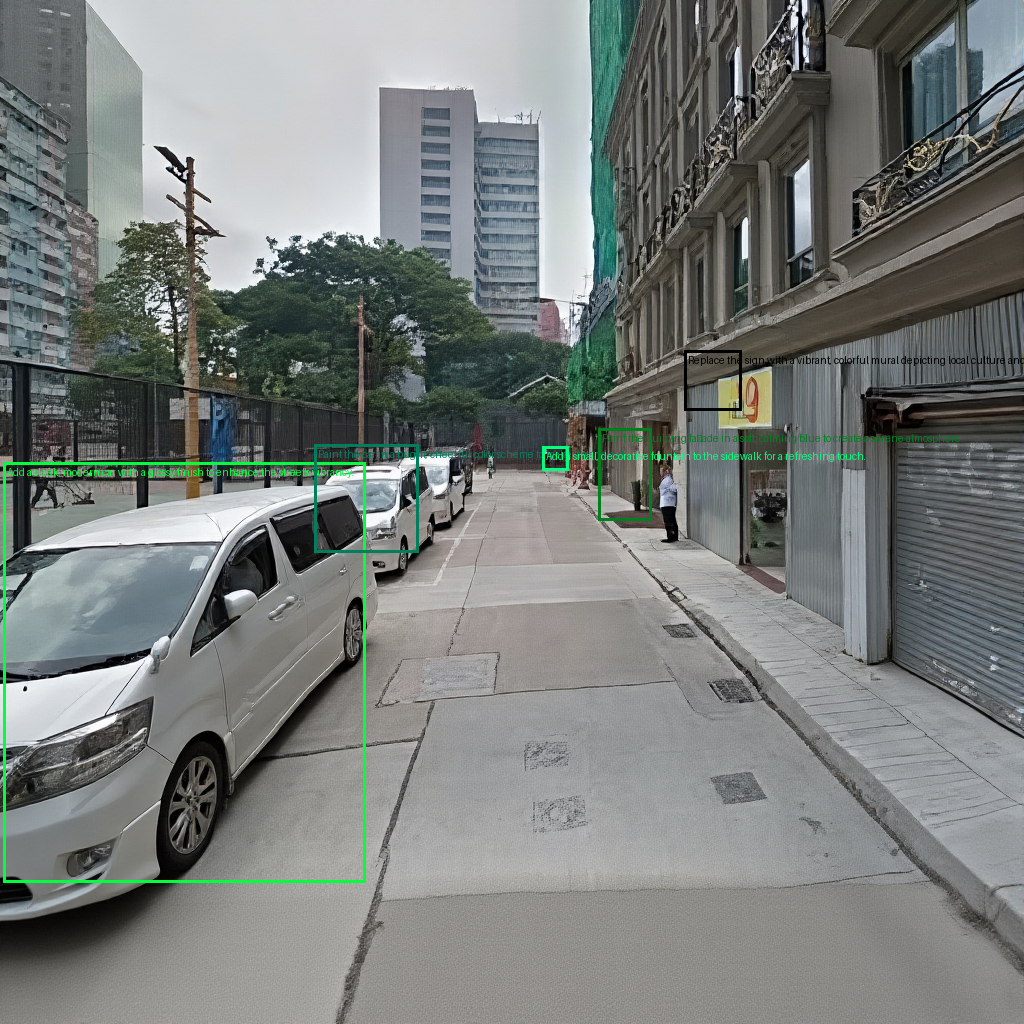

In [48]:

import torchvision.transforms as T
from torchvision.utils import draw_bounding_boxes
import torch

# Suppose 'output' is your list of dicts with 'bbox_2d' and 'prompt'
# Example: output = [{"bbox_2d": [x1, y1, x2, y2], "prompt": "Add a tree"}, ...]

# Convert PIL image to tensor (C, H, W) and scale to [0, 255]
img_tensor = T.ToTensor()(images[0]) * 255
img_tensor = img_tensor.type(torch.uint8)

# Prepare bounding boxes and labels
boxes = torch.tensor([item["bbox_2d"] for item in output], dtype=torch.int)
labels = [item["prompt"] for item in output]

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_tensor, boxes, labels=labels, width=3, font_size=48
)

# Convert back to PIL for display
from torchvision.transforms.functional import to_pil_image
display(to_pil_image(img_with_boxes))